# Statistical Threshold Calibration for AI Assistant Outputs

This notebook implements a **statistical quality gate** for LLM outputs by:

1. **Generating** 100 outputs from the same prompt using GPT-4o-mini
2. **Embedding** all outputs using text-embedding-3-small
3. **Calibrating** a threshold using KDE and bootstrap confidence intervals
4. **Runtime evaluation** with accept/retry/escalate logic
5. **Drift detection** for ongoing monitoring

**Models Used:**
- `gpt-4o-mini` - Cost-effective generation with good quality
- `text-embedding-3-small` - Efficient embeddings for similarity computation

In [1]:
# Core imports
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import gaussian_kde, ks_2samp
import matplotlib.pyplot as plt

from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

print("OpenAI client initialized successfully!")
print(f"Using models: gpt-4o-mini (generation), text-embedding-3-small (embeddings)")

OpenAI client initialized successfully!
Using models: gpt-4o-mini (generation), text-embedding-3-small (embeddings)


## Configuration Constants

Define the key parameters for our calibration experiment.

In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Number of outputs to generate for calibration
N_OUTPUTS = 100

# Temperature for sampling (higher = more diversity)
TEMPERATURE = 0.2

# Model configurations
GENERATION_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-3-small"

# Calibration parameters
THRESHOLD_PERCENTILE = 5  # Use 5th percentile as threshold (95% of good outputs above)
BOOTSTRAP_ITERATIONS = 10000  # Number of bootstrap resamples for CI
CONFIDENCE_LEVEL = 0.95  # 95% confidence interval

# Drift detection parameters
DRIFT_WINDOW_SIZE = 50  # Rolling window for drift monitoring
DRIFT_ALPHA = 0.05  # Significance level for KS test
DRIFT_Z_THRESHOLD = 2  # Z-score threshold for mean shift detection

print(f"Configuration loaded:")
print(f"  - Outputs to generate: {N_OUTPUTS}")
print(f"  - Temperature: {TEMPERATURE}")
print(f"  - Threshold percentile: {THRESHOLD_PERCENTILE}th")
print(f"  - Bootstrap iterations: {BOOTSTRAP_ITERATIONS}")
print(f"  - Drift window size: {DRIFT_WINDOW_SIZE}")

Configuration loaded:
  - Outputs to generate: 100
  - Temperature: 0.2
  - Threshold percentile: 5th
  - Bootstrap iterations: 1000
  - Drift window size: 50


## Prompt Definitions

Define the system prompt (simulating your professional tone) and user prompt for the calibration task.

In [3]:
# =============================================================================
# PROMPT DEFINITIONS
# =============================================================================

# System prompt - Simulates professional AI architect tone
SYSTEM_PROMPT = """
You are an AI assistant that answers like a senior AI architect.

Style guidelines:
- Structured and organized responses
- Use bullet points for clarity
- Be precise and technical
- Minimal fluff - get to the point
- Actionable recommendations
- Professional tone throughout
"""

# User prompt - The question we'll generate multiple responses for
USER_PROMPT = """
Explain how to implement a threshold-based evaluation system to validate
LLM outputs using embeddings and cosine similarity.

Provide:
1. Key steps in the implementation
2. Best practices to consider
3. Potential pitfalls to avoid
"""

print("System Prompt:")
print("-" * 50)
print(SYSTEM_PROMPT.strip())
print()
print("User Prompt:")
print("-" * 50)
print(USER_PROMPT.strip())

System Prompt:
--------------------------------------------------
You are an AI assistant that answers like a senior AI architect.

Style guidelines:
- Structured and organized responses
- Use bullet points for clarity
- Be precise and technical
- Minimal fluff - get to the point
- Actionable recommendations
- Professional tone throughout

User Prompt:
--------------------------------------------------
Explain how to implement a threshold-based evaluation system to validate
LLM outputs using embeddings and cosine similarity.

Provide:
1. Key steps in the implementation
2. Best practices to consider
3. Potential pitfalls to avoid


## Generation Functions

Helper functions to generate outputs using GPT-4o-mini.

In [4]:
def generate_output(system_prompt: str, user_prompt: str, temp: float = 0.9) -> str:
    """
    Generate a single output using GPT-4o-mini.
    
    Args:
        system_prompt: The system prompt defining assistant behavior
        user_prompt: The user's question/request
        temp: Temperature for sampling (higher = more diverse)
    
    Returns:
        Generated text response
    """
    response = client.chat.completions.create(
        model=GENERATION_MODEL,
        temperature=temp,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content


def generate_batch_outputs(system_prompt: str, user_prompt: str, n: int, temp: float = 0.9) -> list[str]:
    """
    Generate N outputs for the same prompt with progress tracking.
    
    Args:
        system_prompt: The system prompt defining assistant behavior
        user_prompt: The user's question/request
        n: Number of outputs to generate
        temp: Temperature for sampling
    
    Returns:
        List of generated text responses
    """
    outputs = []
    for _ in tqdm(range(n), desc="Generating outputs"):
        output = generate_output(system_prompt, user_prompt, temp)
        outputs.append(output)
    return outputs


# Test the generation function
print("Testing generation function...")
test_output = generate_output(SYSTEM_PROMPT, USER_PROMPT, TEMPERATURE)
print(f"Test output length: {len(test_output)} characters")
print(f"First 200 characters: {test_output[:200]}...")

Testing generation function...
Test output length: 3208 characters
First 200 characters: ### Implementation of a Threshold-Based Evaluation System for LLM Outputs

#### 1. Key Steps in the Implementation

- **Data Preparation**
  - Collect a dataset of reference outputs (ground truth) for...


## Embedding Functions

Helper functions to embed texts using text-embedding-3-small.

In [5]:
def embed_texts(texts: list[str]) -> np.ndarray:
    """
    Embed a list of texts using text-embedding-3-small.
    
    Args:
        texts: List of text strings to embed
    
    Returns:
        numpy array of shape (n_texts, embedding_dim)
    """
    response = client.embeddings.create(
        model=EMBEDDING_MODEL,
        input=texts
    )
    return np.array([d.embedding for d in response.data])


def compute_centroid(embeddings: np.ndarray) -> np.ndarray:
    """
    Compute the centroid (mean) of a set of embeddings.
    
    Args:
        embeddings: numpy array of shape (n, dim)
    
    Returns:
        Centroid vector of shape (dim,)
    """
    return embeddings.mean(axis=0)


# Test the embedding function
print("Testing embedding function...")
test_embeddings = embed_texts([test_output])
print(f"Embedding shape: {test_embeddings.shape}")
print(f"Embedding dimension: {test_embeddings.shape[1]}")

Testing embedding function...
Embedding shape: (1, 1536)
Embedding dimension: 1536


## Step 1: Generate Calibration Outputs

Generate N outputs from the same prompt to build our calibration distribution.

In [6]:
# Generate N outputs for calibration
print(f"Generating {N_OUTPUTS} outputs for calibration...")
print(f"This may take a few minutes...")

outputs = generate_batch_outputs(SYSTEM_PROMPT, USER_PROMPT, N_OUTPUTS, TEMPERATURE)

print(f"\nGeneration complete!")
print(f"Total outputs: {len(outputs)}")
print(f"Average output length: {np.mean([len(o) for o in outputs]):.0f} characters")

Generating 100 outputs for calibration...
This may take a few minutes...


Generating outputs: 100%|██████████| 100/100 [23:25<00:00, 14.05s/it]


Generation complete!
Total outputs: 100
Average output length: 3196 characters


## Step 2: Create Reference and Compute Embeddings

Select a reference output and embed all outputs for similarity computation.

In [7]:
# Select reference output (first output as baseline)
# In production, you might use a human-curated "gold" reference
reference_output = outputs[0]

print("Reference output (first 300 chars):")
print("-" * 50)
print(reference_output[:300] + "...")
print()

# Embed all outputs
print("Embedding all outputs...")
embeddings = embed_texts(outputs)
print(f"Embeddings shape: {embeddings.shape}")

# Get reference embedding
ref_embedding = embeddings[0]

# Compute centroid embedding (for self-consistency metric)
centroid = compute_centroid(embeddings)

print(f"Reference embedding shape: {ref_embedding.shape}")
print(f"Centroid embedding shape: {centroid.shape}")

Reference output (first 300 chars):
--------------------------------------------------
### Implementation of a Threshold-Based Evaluation System for LLM Outputs

#### 1. Key Steps in the Implementation

- **Data Preparation**
  - Collect a dataset of expected outputs (ground truth) for the tasks your LLM is performing.
  - Preprocess the data to ensure consistency (e.g., tokenization,...

Embedding all outputs...
Embeddings shape: (100, 1536)
Reference embedding shape: (1536,)
Centroid embedding shape: (1536,)


## Step 3: Compute Similarity Scores

Calculate cosine similarities to reference and centroid for all outputs.

In [9]:
# Compute similarity to reference
sims_to_ref = cosine_similarity(embeddings, ref_embedding.reshape(1, -1)).flatten()

# Compute similarity to centroid (self-consistency metric)
sims_to_centroid = cosine_similarity(embeddings, centroid.reshape(1, -1)).flatten()

print("Similarity to Reference:")
print(f"  Mean: {np.mean(sims_to_ref):.4f}")
print(f"  Std:  {np.std(sims_to_ref):.4f}")
print(f"  Min:  {np.min(sims_to_ref):.4f}")
print(f"  Max:  {np.max(sims_to_ref):.4f}")
print()
print("Similarity to Centroid:")
print(f"  Mean: {np.mean(sims_to_centroid):.4f}")
print(f"  Std:  {np.std(sims_to_centroid):.4f}")
print(f"  Min:  {np.min(sims_to_centroid):.4f}")
print(f"  Max:  {np.max(sims_to_centroid):.4f}")

Similarity to Reference:
  Mean: 0.9754
  Std:  0.0062
  Min:  0.9595
  Max:  1.0000

Similarity to Centroid:
  Mean: 0.9869
  Std:  0.0037
  Min:  0.9623
  Max:  0.9910


## Step 4: Visualize Similarity Distributions

Examine the distribution of similarities to understand the output consistency.

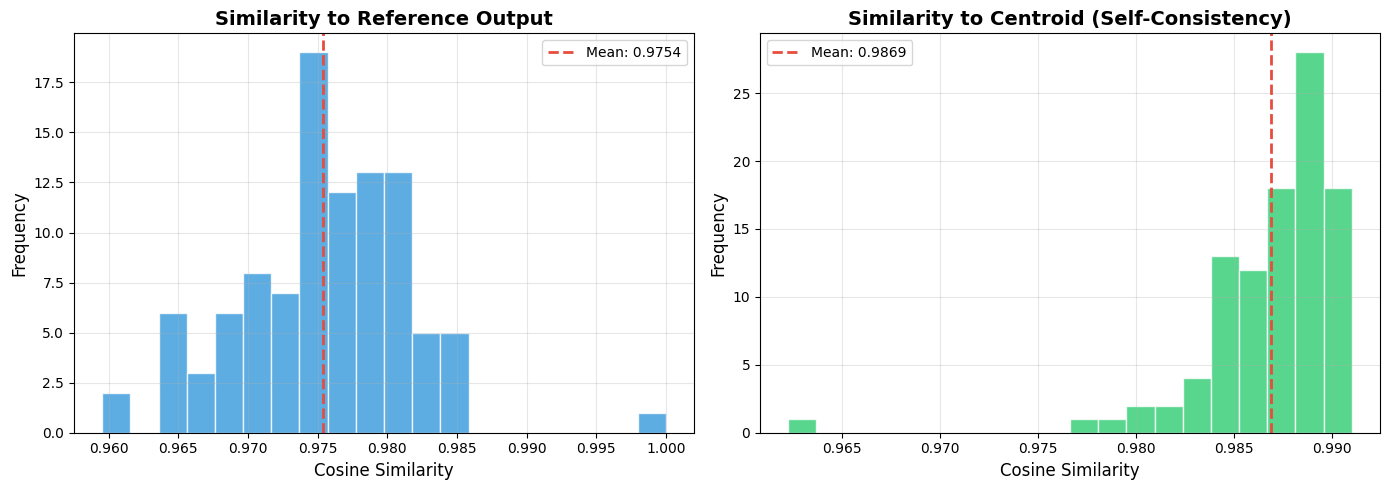

In [10]:
# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram: Similarity to Reference
ax1 = axes[0]
ax1.hist(sims_to_ref, bins=20, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(np.mean(sims_to_ref), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims_to_ref):.4f}')
ax1.set_xlabel('Cosine Similarity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Similarity to Reference Output', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histogram: Similarity to Centroid
ax2 = axes[1]
ax2.hist(sims_to_centroid, bins=20, color='#2ecc71', edgecolor='white', alpha=0.8)
ax2.axvline(np.mean(sims_to_centroid), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims_to_centroid):.4f}')
ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Similarity to Centroid (Self-Consistency)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: KDE Modeling

Fit a Kernel Density Estimate to model the smooth distribution of similarity scores.

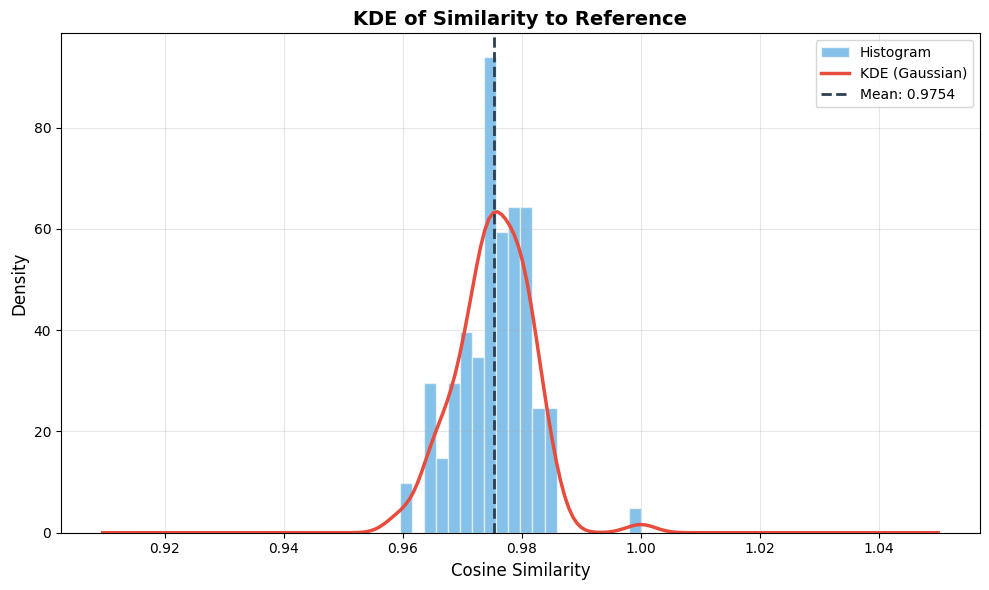

KDE fitted successfully


In [11]:
# Fit KDE to similarity-to-reference distribution
kde = gaussian_kde(sims_to_ref)

# Create smooth x-axis for plotting
x_range = np.linspace(min(sims_to_ref) - 0.05, max(sims_to_ref) + 0.05, 200)
kde_values = kde(x_range)

# Plot KDE
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram with density
ax.hist(sims_to_ref, bins=20, density=True, color='#3498db', edgecolor='white', alpha=0.6, label='Histogram')

# KDE curve
ax.plot(x_range, kde_values, color='#e74c3c', linewidth=2.5, label='KDE (Gaussian)')

# Mark mean
ax.axvline(np.mean(sims_to_ref), color='#2c3e50', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims_to_ref):.4f}')

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('KDE of Similarity to Reference', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"KDE fitted successfully")

## Step 6: Threshold Calibration

Calculate the threshold at the configured percentile (default: 5th percentile).

This means 95% of acceptable outputs will be **above** this threshold.

In [12]:
# Calculate threshold at different percentiles
threshold_1pct = np.percentile(sims_to_ref, 1)
threshold_5pct = np.percentile(sims_to_ref, 5)
threshold_10pct = np.percentile(sims_to_ref, 10)

# Use configured percentile as our main threshold
threshold = np.percentile(sims_to_ref, THRESHOLD_PERCENTILE)

print("Threshold Calibration Results:")
print("=" * 50)
print(f"  1st percentile threshold:  {threshold_1pct:.4f}")
print(f"  5th percentile threshold:  {threshold_5pct:.4f} {'<-- SELECTED' if THRESHOLD_PERCENTILE == 5 else ''}")
print(f"  10th percentile threshold: {threshold_10pct:.4f}")
print("=" * 50)
print(f"\nCalibrated Threshold: {threshold:.4f}")
print(f"Interpretation: {100 - THRESHOLD_PERCENTILE}% of outputs are above this threshold")

Threshold Calibration Results:
  1st percentile threshold:  0.9598
  5th percentile threshold:  0.9650 <-- SELECTED
  10th percentile threshold: 0.9672

Calibrated Threshold: 0.9650
Interpretation: 95% of outputs are above this threshold


## Step 7: Bootstrap Confidence Interval

Compute a confidence interval for our threshold using bootstrap resampling.

This gives us statistical rigor and uncertainty bounds.

In [13]:
# Bootstrap resampling for confidence interval
np.random.seed(42)  # For reproducibility

bootstrap_thresholds = []

print(f"Running {BOOTSTRAP_ITERATIONS} bootstrap iterations...")
for _ in tqdm(range(BOOTSTRAP_ITERATIONS)):
    # Resample with replacement
    sample = np.random.choice(sims_to_ref, size=len(sims_to_ref), replace=True)
    # Calculate threshold for this sample
    sample_threshold = np.percentile(sample, THRESHOLD_PERCENTILE)
    bootstrap_thresholds.append(sample_threshold)

bootstrap_thresholds = np.array(bootstrap_thresholds)

# Calculate confidence interval
alpha = 1 - CONFIDENCE_LEVEL
ci_low = np.percentile(bootstrap_thresholds, (alpha / 2) * 100)
ci_high = np.percentile(bootstrap_thresholds, (1 - alpha / 2) * 100)

print(f"\nBootstrap Results:")
print("=" * 50)
print(f"  Point Estimate (Threshold): {threshold:.4f}")
print(f"  {CONFIDENCE_LEVEL * 100:.0f}% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"  CI Width: {ci_high - ci_low:.4f}")
print("=" * 50)

Running 1000 bootstrap iterations...


100%|██████████| 1000/1000 [00:00<00:00, 14237.82it/s]


Bootstrap Results:
  Point Estimate (Threshold): 0.9650
  95% Confidence Interval: [0.9638, 0.9679]
  CI Width: 0.0041


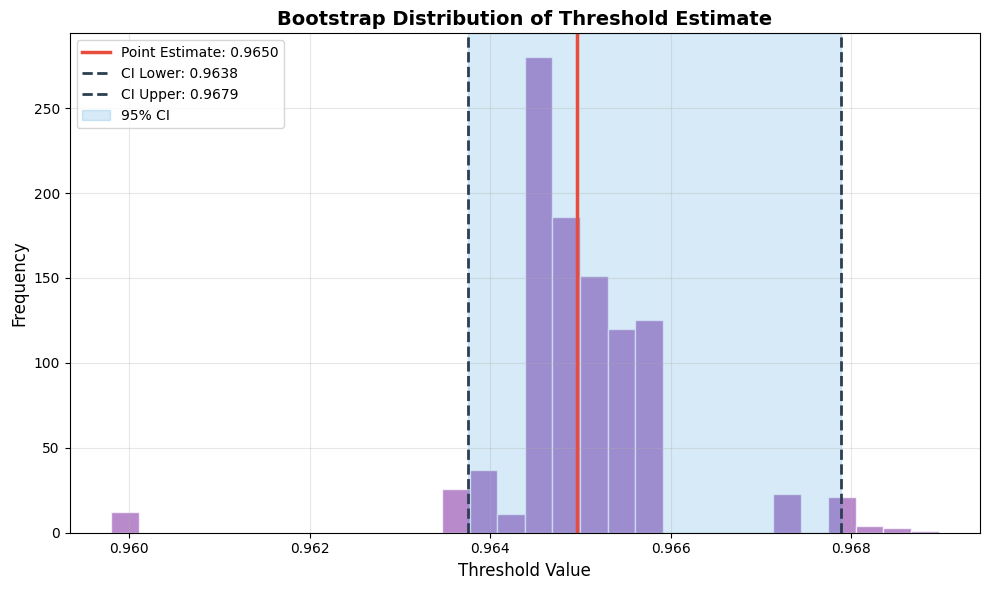

In [14]:
# Visualize bootstrap distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(bootstrap_thresholds, bins=30, color='#9b59b6', edgecolor='white', alpha=0.7)
ax.axvline(threshold, color='#e74c3c', linestyle='-', linewidth=2.5, label=f'Point Estimate: {threshold:.4f}')
ax.axvline(ci_low, color='#2c3e50', linestyle='--', linewidth=2, label=f'CI Lower: {ci_low:.4f}')
ax.axvline(ci_high, color='#2c3e50', linestyle='--', linewidth=2, label=f'CI Upper: {ci_high:.4f}')

# Shade CI region
ax.axvspan(ci_low, ci_high, alpha=0.2, color='#3498db', label=f'{CONFIDENCE_LEVEL * 100:.0f}% CI')

ax.set_xlabel('Threshold Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Bootstrap Distribution of Threshold Estimate', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Runtime Evaluation Functions

Create functions to evaluate new outputs against the calibrated threshold.

In [15]:
def evaluate_output_score(text: str, ref_emb: np.ndarray) -> float:
    """
    Compute similarity score for a single output.
    
    Args:
        text: The output text to evaluate
        ref_emb: Reference embedding to compare against
    
    Returns:
        Cosine similarity score
    """
    emb = embed_texts([text])[0]
    score = cosine_similarity(emb.reshape(1, -1), ref_emb.reshape(1, -1))[0][0]
    return score


def evaluate_output(text: str, ref_emb: np.ndarray, threshold: float) -> tuple[bool, float]:
    """
    Evaluate if an output passes the threshold.
    
    Args:
        text: The output text to evaluate
        ref_emb: Reference embedding to compare against
        threshold: Minimum similarity threshold
    
    Returns:
        Tuple of (passed: bool, score: float)
    """
    score = evaluate_output_score(text, ref_emb)
    passed = score >= threshold
    return passed, score


def evaluate_with_retry(
    system_prompt: str,
    user_prompt: str,
    ref_emb: np.ndarray,
    threshold: float,
    max_retries: int = 3,
    temp: float = 0.9
) -> tuple[str, float, str, int]:
    """
    Generate output with retry logic if below threshold.
    
    Args:
        system_prompt: System prompt for generation
        user_prompt: User prompt for generation
        ref_emb: Reference embedding
        threshold: Minimum similarity threshold
        max_retries: Maximum number of attempts
        temp: Temperature for generation
    
    Returns:
        Tuple of (output, score, decision, attempts)
        Decision is one of: "ACCEPT", "ESCALATE"
    """
    for attempt in range(max_retries):
        output = generate_output(system_prompt, user_prompt, temp)
        passed, score = evaluate_output(output, ref_emb, threshold)
        
        if passed:
            return output, score, "ACCEPT", attempt + 1
    
    # All retries exhausted
    return output, score, "ESCALATE", max_retries


print("Runtime evaluation functions defined:")

Runtime evaluation functions defined:


## Step 9: Test Runtime Evaluation

Test the evaluation function with a new generated output.

In [16]:
# Generate a new test output
print("Generating new test output...")
new_output = generate_output(SYSTEM_PROMPT, USER_PROMPT, TEMPERATURE)

# Evaluate against threshold
passed, score = evaluate_output(new_output, ref_embedding, threshold)

print("\n" + "=" * 60)
print("RUNTIME EVALUATION RESULT")
print("=" * 60)
print(f"Score:     {score:.4f}")
print(f"Threshold: {threshold:.4f}")
print(f"CI:        [{ci_low:.4f}, {ci_high:.4f}]")
print("-" * 60)

if passed:
    print(f"Decision:  ACCEPT")
else:
    print(f"Decision:  RETRY (score below threshold)")
    
print("=" * 60)

Generating new test output...

RUNTIME EVALUATION RESULT
Score:     0.9744
Threshold: 0.9650
CI:        [0.9638, 0.9679]
------------------------------------------------------------
Decision:  ACCEPT


In [17]:
# Test the retry logic (with higher threshold to force retries)
print("Testing accept/retry/escalate logic...")
print("(Using slightly higher threshold to demonstrate retry behavior)")

# Use a threshold that will likely trigger at least one retry
test_threshold = np.percentile(sims_to_ref, 50)  # 50th percentile = median

output, score, decision, attempts = evaluate_with_retry(
    SYSTEM_PROMPT, USER_PROMPT, ref_embedding, 
    test_threshold, max_retries=3
)

print(f"\nResult:")
print(f"  Decision: {decision}")
print(f"  Attempts: {attempts}")
print(f"  Final Score: {score:.4f}")
print(f"  Test Threshold: {test_threshold:.4f}")

Testing accept/retry/escalate logic...
(Using slightly higher threshold to demonstrate retry behavior)

Result:
  Decision: ESCALATE
  Attempts: 3
  Final Score: 0.9657
  Test Threshold: 0.9755


## Step 9b: Hypothesis Testing for Output Evaluation

Add formal statistical hypothesis testing to make accept/reject decisions more rigorous.

### Hypothesis Framework

```
H0 (Null Hypothesis):     The output similarity score is at or below the threshold (score ≤ T)
H1 (Alternative):         The output similarity score is above the threshold (score > T)

Decision Rule:
- p-value < α  →  Reject H0  →  ACCEPT output (statistically confident it exceeds threshold)
- p-value ≥ α  →  Fail to reject H0  →  RETRY/ESCALATE (insufficient evidence)
```

### Why This Approach?

- **Conservative by default**: Assumes output is NOT acceptable until proven otherwise
- **Controls false acceptance rate**: Setting α=0.05 means at most 5% chance of accepting bad output
- **Two evaluation modes**:
  - **Single output**: Z-test using calibration distribution parameters
  - **Batch output**: T-test for multiple outputs (more robust for small samples)

In [18]:
from scipy.stats import norm, ttest_1samp

def evaluate_output_hypothesis(
    text: str, 
    ref_emb: np.ndarray, 
    threshold: float,
    baseline_mean: float,
    baseline_std: float,
    alpha: float = 0.05
) -> dict:
    """
    Evaluate a single output using hypothesis testing.
    
    Hypothesis:
        H0: score <= threshold (output is NOT acceptable)
        H1: score > threshold (output IS acceptable)
    
    Uses z-test with calibration distribution parameters.
    
    Args:
        text: Output text to evaluate
        ref_emb: Reference embedding
        threshold: Calibrated threshold value
        baseline_mean: Mean from calibration distribution
        baseline_std: Std from calibration distribution
        alpha: Significance level (default 0.05)
    
    Returns:
        Dictionary with score, z_score, p_value, and decision
    """
    # Compute similarity score
    score = evaluate_output_score(text, ref_emb)
    
    # Z-score: how many standard deviations above the threshold
    z_score = (score - threshold) / baseline_std
    
    # One-tailed p-value (upper tail)
    # P(Z > z_score) under H0
    p_value = 1 - norm.cdf(z_score)
    
    # Decision based on significance level
    reject_h0 = p_value < alpha
    decision = "ACCEPT" if reject_h0 else "RETRY"
    
    return {
        "score": float(score),
        "threshold": float(threshold),
        "z_score": float(z_score),
        "p_value": float(p_value),
        "alpha": alpha,
        "reject_h0": reject_h0,
        "decision": decision,
        "interpretation": f"{'Reject' if reject_h0 else 'Fail to reject'} H0 at α={alpha}"
    }


print("Single output hypothesis test function defined")

Single output hypothesis test function defined


In [19]:
def evaluate_batch_hypothesis(
    scores: np.ndarray,
    threshold: float,
    alpha: float = 0.05
) -> dict:
    """
    Evaluate a batch of outputs using one-sample t-test.
    
    Hypothesis:
        H0: mean(scores) <= threshold (batch is NOT acceptable on average)
        H1: mean(scores) > threshold (batch IS acceptable on average)
    
    Uses t-test which is more robust for small samples.
    
    Args:
        scores: Array of similarity scores
        threshold: Calibrated threshold value
        alpha: Significance level (default 0.05)
    
    Returns:
        Dictionary with statistics, p_value, and decision
    """
    # One-sample t-test
    t_stat, p_value_two_tailed = ttest_1samp(scores, threshold)
    
    # Convert to one-tailed (we only care if mean > threshold)
    # If t_stat > 0, mean is above threshold, use half the two-tailed p-value
    # If t_stat < 0, mean is below threshold, p-value for upper tail is 1 - half
    if t_stat > 0:
        p_value = p_value_two_tailed / 2
    else:
        p_value = 1 - p_value_two_tailed / 2
    
    # Decision
    reject_h0 = p_value < alpha
    decision = "ACCEPT" if reject_h0 else "ESCALATE"
    
    return {
        "n_samples": len(scores),
        "mean_score": float(np.mean(scores)),
        "std_score": float(np.std(scores, ddof=1)),  # Sample std
        "threshold": float(threshold),
        "t_statistic": float(t_stat),
        "p_value": float(p_value),
        "alpha": alpha,
        "reject_h0": reject_h0,
        "decision": decision,
        "interpretation": f"{'Reject' if reject_h0 else 'Fail to reject'} H0 at α={alpha}"
    }


def generate_and_test_batch(
    system_prompt: str,
    user_prompt: str,
    ref_emb: np.ndarray,
    threshold: float,
    n_samples: int = 10,
    temp: float = 0.9,
    alpha: float = 0.05
) -> dict:
    """
    Generate a batch of outputs and run hypothesis test.
    
    Args:
        system_prompt: System prompt for generation
        user_prompt: User prompt for generation
        ref_emb: Reference embedding
        threshold: Calibrated threshold
        n_samples: Number of outputs to generate
        temp: Temperature for generation
        alpha: Significance level
    
    Returns:
        Dictionary with outputs, scores, and hypothesis test results
    """
    # Generate outputs
    outputs = generate_batch_outputs(system_prompt, user_prompt, n_samples, temp)
    
    # Embed and compute scores
    embeddings = embed_texts(outputs)
    scores = cosine_similarity(embeddings, ref_emb.reshape(1, -1)).flatten()
    
    # Run hypothesis test
    test_result = evaluate_batch_hypothesis(scores, threshold, alpha)
    
    return {
        "outputs": outputs,
        "scores": scores,
        "test_result": test_result
    }


print("Batch hypothesis test functions defined")

Batch hypothesis test functions defined


In [20]:
# Store baseline statistics for hypothesis testing
# (These are also used later for drift detection)
baseline_stats = {
    "scores": sims_to_ref.copy(),
    "mean": np.mean(sims_to_ref),
    "std": np.std(sims_to_ref),
    "kde": kde,
    "threshold": threshold,
    "ci_low": ci_low,
    "ci_high": ci_high
}

print("Baseline Statistics for Hypothesis Testing:")
print(f"  Mean: {baseline_stats['mean']:.4f}")
print(f"  Std:  {baseline_stats['std']:.4f}")
print(f"  N samples: {len(baseline_stats['scores'])}")

Baseline Statistics for Hypothesis Testing:
  Mean: 0.9754
  Std:  0.0062
  N samples: 100


### Test: Single Output Hypothesis Evaluation

In [21]:
# Test single output hypothesis evaluation
print("Generating new output for hypothesis test...")
test_output_hyp = generate_output(SYSTEM_PROMPT, USER_PROMPT, TEMPERATURE)

# Run hypothesis test
hyp_result = evaluate_output_hypothesis(
    text=test_output_hyp,
    ref_emb=ref_embedding,
    threshold=threshold,
    baseline_mean=baseline_stats["mean"],
    baseline_std=baseline_stats["std"],
    alpha=0.05
)

print("\n" + "=" * 70)
print("SINGLE OUTPUT HYPOTHESIS TEST RESULT")
print("=" * 70)
print(f"H0: Score ≤ {hyp_result['threshold']:.4f} (output not acceptable)")
print(f"H1: Score > {hyp_result['threshold']:.4f} (output acceptable)")
print("-" * 70)
print(f"Observed Score:  {hyp_result['score']:.4f}")
print(f"Threshold:       {hyp_result['threshold']:.4f}")
print(f"Z-Score:         {hyp_result['z_score']:.4f}")
print(f"P-Value:         {hyp_result['p_value']:.6f}")
print(f"Alpha (α):       {hyp_result['alpha']}")
print("-" * 70)
print(f"Decision:        {hyp_result['interpretation']}")
print(f"Action:          {hyp_result['decision']}")
print("=" * 70)

if hyp_result['reject_h0']:
    print("\nInterpretation: There is statistically significant evidence")
    print(f"that the output exceeds the threshold (p={hyp_result['p_value']:.4f} < α={hyp_result['alpha']})")
else:
    print("\nInterpretation: Insufficient evidence to conclude the output")
    print(f"exceeds the threshold (p={hyp_result['p_value']:.4f} ≥ α={hyp_result['alpha']})")

Generating new output for hypothesis test...

SINGLE OUTPUT HYPOTHESIS TEST RESULT
H0: Score ≤ 0.9650 (output not acceptable)
H1: Score > 0.9650 (output acceptable)
----------------------------------------------------------------------
Observed Score:  0.9801
Threshold:       0.9650
Z-Score:         2.4574
P-Value:         0.006998
Alpha (α):       0.05
----------------------------------------------------------------------
Decision:        Reject H0 at α=0.05
Action:          ACCEPT

Interpretation: There is statistically significant evidence
that the output exceeds the threshold (p=0.0070 < α=0.05)


### Test: Batch Output Hypothesis Evaluation

Generate multiple outputs and use t-test for more robust statistical inference.

In [22]:
# Test batch hypothesis evaluation
N_BATCH_SAMPLES = 15  # Generate 15 outputs for the test

print(f"Generating {N_BATCH_SAMPLES} outputs for batch hypothesis test...")
batch_result = generate_and_test_batch(
    system_prompt=SYSTEM_PROMPT,
    user_prompt=USER_PROMPT,
    ref_emb=ref_embedding,
    threshold=threshold,
    n_samples=N_BATCH_SAMPLES,
    temp=TEMPERATURE,
    alpha=0.05
)

test_result = batch_result["test_result"]
batch_scores = batch_result["scores"]

print("\n" + "=" * 70)
print("BATCH OUTPUT HYPOTHESIS TEST RESULT (T-Test)")
print("=" * 70)
print(f"H0: Mean(scores) ≤ {test_result['threshold']:.4f} (batch not acceptable on average)")
print(f"H1: Mean(scores) > {test_result['threshold']:.4f} (batch acceptable on average)")
print("-" * 70)
print(f"Sample Size (n):    {test_result['n_samples']}")
print(f"Mean Score:         {test_result['mean_score']:.4f}")
print(f"Std Score:          {test_result['std_score']:.4f}")
print(f"Threshold:          {test_result['threshold']:.4f}")
print(f"T-Statistic:        {test_result['t_statistic']:.4f}")
print(f"P-Value:            {test_result['p_value']:.6f}")
print(f"Alpha (α):          {test_result['alpha']}")
print("-" * 70)
print(f"Decision:           {test_result['interpretation']}")
print(f"Action:             {test_result['decision']}")
print("=" * 70)

# Show individual scores
print(f"\nIndividual Scores (sorted):")
for i, score in enumerate(sorted(batch_scores, reverse=True)):
    status = "above" if score >= threshold else "BELOW"
    print(f"  {i+1:2}. {score:.4f} ({status} threshold)")

Generating 15 outputs for batch hypothesis test...


Generating outputs: 100%|██████████| 15/15 [02:55<00:00, 11.67s/it]



BATCH OUTPUT HYPOTHESIS TEST RESULT (T-Test)
H0: Mean(scores) ≤ 0.9650 (batch not acceptable on average)
H1: Mean(scores) > 0.9650 (batch acceptable on average)
----------------------------------------------------------------------
Sample Size (n):    15
Mean Score:         0.9770
Std Score:          0.0045
Threshold:          0.9650
T-Statistic:        10.3767
P-Value:            0.000000
Alpha (α):          0.05
----------------------------------------------------------------------
Decision:           Reject H0 at α=0.05
Action:             ACCEPT

Individual Scores (sorted):
   1. 0.9841 (above threshold)
   2. 0.9839 (above threshold)
   3. 0.9822 (above threshold)
   4. 0.9795 (above threshold)
   5. 0.9790 (above threshold)
   6. 0.9782 (above threshold)
   7. 0.9769 (above threshold)
   8. 0.9765 (above threshold)
   9. 0.9763 (above threshold)
  10. 0.9761 (above threshold)
  11. 0.9759 (above threshold)
  12. 0.9748 (above threshold)
  13. 0.9733 (above threshold)
  14. 0.971

### Visualization: Hypothesis Test Results

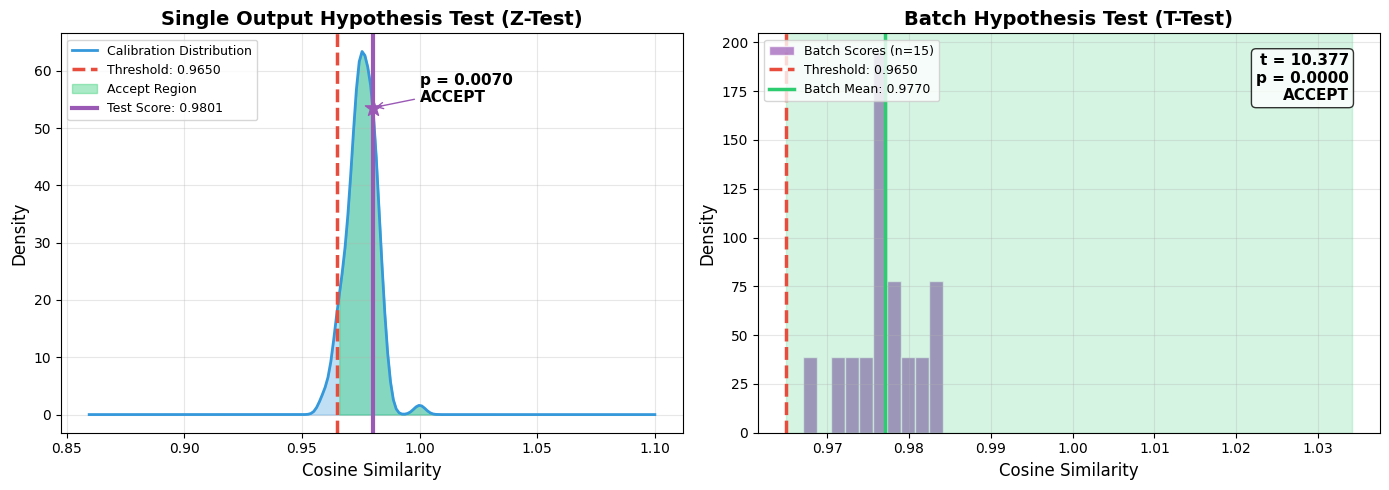


HYPOTHESIS TESTING SUMMARY
Single Output Test:  ACCEPT (p = 0.0070)
Batch Test (n=15):     ACCEPT (p = 0.0000)


In [23]:
# Visualize hypothesis test results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# === Left Plot: Single Output Z-Test Visualization ===
ax1 = axes[0]

# Plot the calibration distribution
x_range = np.linspace(
    min(baseline_stats["scores"]) - 0.1, 
    max(baseline_stats["scores"]) + 0.1, 
    200
)
kde_baseline = gaussian_kde(baseline_stats["scores"])
ax1.plot(x_range, kde_baseline(x_range), color='#3498db', linewidth=2, label='Calibration Distribution')
ax1.fill_between(x_range, kde_baseline(x_range), alpha=0.3, color='#3498db')

# Mark threshold
ax1.axvline(threshold, color='#e74c3c', linestyle='--', linewidth=2.5, label=f'Threshold: {threshold:.4f}')

# Shade rejection region (above threshold = ACCEPT zone)
x_accept = x_range[x_range >= threshold]
ax1.fill_between(x_accept, kde_baseline(x_accept), alpha=0.4, color='#2ecc71', label='Accept Region')

# Mark the test output score
ax1.axvline(hyp_result['score'], color='#9b59b6', linestyle='-', linewidth=3, 
            label=f'Test Score: {hyp_result["score"]:.4f}')
ax1.scatter([hyp_result['score']], [kde_baseline(hyp_result['score'])], 
            color='#9b59b6', s=150, zorder=5, marker='*')

# Add p-value annotation
ax1.annotate(f'p = {hyp_result["p_value"]:.4f}\n{hyp_result["decision"]}', 
             xy=(hyp_result['score'], kde_baseline(hyp_result['score'])),
             xytext=(hyp_result['score'] + 0.02, kde_baseline(hyp_result['score']) + 1),
             fontsize=11, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='#9b59b6'))

ax1.set_xlabel('Cosine Similarity', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Single Output Hypothesis Test (Z-Test)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# === Right Plot: Batch T-Test Visualization ===
ax2 = axes[1]

# Histogram of batch scores
ax2.hist(batch_scores, bins=10, color='#9b59b6', edgecolor='white', alpha=0.7, 
         label=f'Batch Scores (n={len(batch_scores)})', density=True)

# Mark threshold
ax2.axvline(threshold, color='#e74c3c', linestyle='--', linewidth=2.5, 
            label=f'Threshold: {threshold:.4f}')

# Mark batch mean
ax2.axvline(test_result['mean_score'], color='#2ecc71', linestyle='-', linewidth=2.5, 
            label=f'Batch Mean: {test_result["mean_score"]:.4f}')

# Shade based on decision
if test_result['reject_h0']:
    ax2.axvspan(threshold, max(batch_scores) + 0.05, alpha=0.2, color='#2ecc71')
else:
    ax2.axvspan(min(batch_scores) - 0.05, threshold, alpha=0.2, color='#e74c3c')

# Add annotation
result_text = f't = {test_result["t_statistic"]:.3f}\np = {test_result["p_value"]:.4f}\n{test_result["decision"]}'
ax2.annotate(result_text, xy=(0.95, 0.95), xycoords='axes fraction',
             fontsize=11, fontweight='bold', ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Batch Hypothesis Test (T-Test)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 70)
print("HYPOTHESIS TESTING SUMMARY")
print("=" * 70)
print(f"Single Output Test:  {hyp_result['decision']} (p = {hyp_result['p_value']:.4f})")
print(f"Batch Test (n={test_result['n_samples']}):     {test_result['decision']} (p = {test_result['p_value']:.4f})")
print("=" * 70)

## Step 10: Drift Detection

Implement drift detection to monitor when the model behavior changes and recalibration may be needed.

In [24]:
# baseline_stats was already computed in the hypothesis testing section
# Verify it's available for drift detection
print("Baseline Statistics (from earlier calibration):")
print(f"  Mean: {baseline_stats['mean']:.4f}")
print(f"  Std:  {baseline_stats['std']:.4f}")
print(f"  N samples: {len(baseline_stats['scores'])}")

Baseline Statistics (from earlier calibration):
  Mean: 0.9754
  Std:  0.0062
  N samples: 100


In [25]:
def detect_drift_ks(baseline_scores: np.ndarray, new_scores: np.ndarray, alpha: float = 0.05) -> dict:
    """
    Detect drift using the Kolmogorov-Smirnov test.
    
    The KS test compares two distributions and detects if they're statistically different.
    
    Args:
        baseline_scores: Array of baseline similarity scores
        new_scores: Array of new similarity scores
        alpha: Significance level (default 0.05)
    
    Returns:
        Dictionary with drift_detected, ks_statistic, p_value
    """
    statistic, p_value = ks_2samp(baseline_scores, new_scores)
    drift_detected = p_value < alpha
    
    return {
        "drift_detected": drift_detected,
        "ks_statistic": statistic,
        "p_value": p_value,
        "alpha": alpha
    }


def detect_drift_mean(
    baseline_scores: np.ndarray, 
    new_scores: np.ndarray, 
    z_threshold: float = 2.0
) -> dict:
    """
    Detect drift by checking if the mean has shifted significantly.
    
    Args:
        baseline_scores: Array of baseline similarity scores
        new_scores: Array of new similarity scores
        z_threshold: Number of standard deviations for drift detection
    
    Returns:
        Dictionary with drift_detected, z_score, baseline_mean, new_mean
    """
    baseline_mean = np.mean(baseline_scores)
    baseline_std = np.std(baseline_scores)
    new_mean = np.mean(new_scores)
    
    # Calculate z-score of the difference
    z_score = abs(new_mean - baseline_mean) / (baseline_std / np.sqrt(len(new_scores)))
    drift_detected = z_score > z_threshold
    
    return {
        "drift_detected": drift_detected,
        "z_score": z_score,
        "baseline_mean": baseline_mean,
        "new_mean": new_mean,
        "z_threshold": z_threshold
    }


print("Drift detection functions defined:")

Drift detection functions defined:


In [26]:
class DriftMonitor:
    """
    Rolling window drift monitor for production use.
    
    Continuously monitors similarity scores and alerts when drift is detected.
    """
    
    def __init__(
        self, 
        baseline_scores: np.ndarray, 
        window_size: int = 50,
        ks_alpha: float = 0.05,
        z_threshold: float = 2.0
    ):
        """
        Initialize the drift monitor.
        
        Args:
            baseline_scores: Calibration baseline scores
            window_size: Size of rolling window for new scores
            ks_alpha: Significance level for KS test
            z_threshold: Z-score threshold for mean shift
        """
        self.baseline = baseline_scores.copy()
        self.window_size = window_size
        self.ks_alpha = ks_alpha
        self.z_threshold = z_threshold
        self.recent_scores = []
        self.drift_history = []
        
    def add_score(self, score: float):
        """Add a new score to the monitoring window."""
        self.recent_scores.append(score)
        if len(self.recent_scores) > self.window_size:
            self.recent_scores.pop(0)
            
    def check_drift(self) -> dict:
        """
        Check for drift in the current window.
        
        Returns:
            Dictionary with drift status and details
        """
        if len(self.recent_scores) < self.window_size:
            return {
                "status": "INSUFFICIENT_DATA",
                "message": f"Need {self.window_size - len(self.recent_scores)} more samples",
                "drift_detected": None
            }
        
        recent_array = np.array(self.recent_scores)
        
        # Run both drift tests
        ks_result = detect_drift_ks(self.baseline, recent_array, self.ks_alpha)
        mean_result = detect_drift_mean(self.baseline, recent_array, self.z_threshold)
        
        # Combined drift detection
        drift_detected = ks_result["drift_detected"] or mean_result["drift_detected"]
        
        result = {
            "status": "DRIFT_DETECTED" if drift_detected else "STABLE",
            "drift_detected": drift_detected,
            "ks_test": ks_result,
            "mean_shift": mean_result,
            "window_size": len(self.recent_scores),
            "recent_mean": np.mean(recent_array),
            "recent_std": np.std(recent_array)
        }
        
        self.drift_history.append(result)
        return result
    
    def get_summary(self) -> dict:
        """Get summary of drift monitoring."""
        return {
            "baseline_mean": np.mean(self.baseline),
            "baseline_std": np.std(self.baseline),
            "current_window_size": len(self.recent_scores),
            "target_window_size": self.window_size,
            "drift_checks_performed": len(self.drift_history),
            "drifts_detected": sum(1 for h in self.drift_history if h.get("drift_detected", False))
        }


# Create drift monitor instance
drift_monitor = DriftMonitor(
    baseline_stats["scores"],
    window_size=DRIFT_WINDOW_SIZE,
    ks_alpha=DRIFT_ALPHA,
    z_threshold=DRIFT_Z_THRESHOLD
)

print("DriftMonitor initialized:")
print(f"  Window size: {DRIFT_WINDOW_SIZE}")
print(f"  KS alpha: {DRIFT_ALPHA}")
print(f"  Z-threshold: {DRIFT_Z_THRESHOLD}")

DriftMonitor initialized:
  Window size: 50
  KS alpha: 0.05
  Z-threshold: 2


## Step 11: Simulate Drift Scenario

Demonstrate drift detection by simulating a change in model behavior.

In [27]:
# Simulate drift by generating outputs with a modified prompt
# This simulates what happens when the system prompt changes or model behavior shifts

DRIFTED_SYSTEM_PROMPT = """
You are a casual AI chatbot that answers questions informally.

Style guidelines:
- Be conversational and friendly
- Use simple language
- Add emojis occasionally
- Keep responses short and casual
"""

print("Simulating drift scenario...")
print("Generating outputs with MODIFIED system prompt to induce drift...")

# Generate a smaller set of "drifted" outputs
N_DRIFT_SAMPLES = 20
drifted_outputs = generate_batch_outputs(DRIFTED_SYSTEM_PROMPT, USER_PROMPT, N_DRIFT_SAMPLES, TEMPERATURE)

# Embed drifted outputs
drifted_embeddings = embed_texts(drifted_outputs)

# Compute similarity to SAME reference (from baseline)
drifted_sims = cosine_similarity(drifted_embeddings, ref_embedding.reshape(1, -1)).flatten()

print(f"\nDrifted outputs statistics:")
print(f"  Mean similarity: {np.mean(drifted_sims):.4f} (baseline: {baseline_stats['mean']:.4f})")
print(f"  Std similarity:  {np.std(drifted_sims):.4f} (baseline: {baseline_stats['std']:.4f})")

Simulating drift scenario...
Generating outputs with MODIFIED system prompt to induce drift...


Generating outputs: 100%|██████████| 20/20 [02:46<00:00,  8.35s/it]



Drifted outputs statistics:
  Mean similarity: 0.8086 (baseline: 0.9754)
  Std similarity:  0.0316 (baseline: 0.0062)


In [28]:
# Run drift detection on the drifted samples
print("Running drift detection...")
print("=" * 60)

# KS Test
ks_result = detect_drift_ks(baseline_stats["scores"], drifted_sims, DRIFT_ALPHA)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  KS Statistic: {ks_result['ks_statistic']:.4f}")
print(f"  P-value:      {ks_result['p_value']:.6f}")
print(f"  Alpha:        {ks_result['alpha']}")
print(f"  Drift Detected: {'YES' if ks_result['drift_detected'] else 'NO'}")

# Mean Shift
mean_result = detect_drift_mean(baseline_stats["scores"], drifted_sims, DRIFT_Z_THRESHOLD)
print(f"\nMean Shift Test:")
print(f"  Baseline Mean: {mean_result['baseline_mean']:.4f}")
print(f"  New Mean:      {mean_result['new_mean']:.4f}")
print(f"  Z-Score:       {mean_result['z_score']:.4f}")
print(f"  Z-Threshold:   {mean_result['z_threshold']}")
print(f"  Drift Detected: {'YES' if mean_result['drift_detected'] else 'NO'}")

print("=" * 60)
combined_drift = ks_result['drift_detected'] or mean_result['drift_detected']
print(f"\nCOMBINED RESULT: {'DRIFT DETECTED - Recalibration recommended!' if combined_drift else 'No significant drift detected'}")

Running drift detection...

Kolmogorov-Smirnov Test:
  KS Statistic: 1.0000
  P-value:      0.000000
  Alpha:        0.05
  Drift Detected: YES

Mean Shift Test:
  Baseline Mean: 0.9754
  New Mean:      0.8086
  Z-Score:       120.8646
  Z-Threshold:   2
  Drift Detected: YES

COMBINED RESULT: DRIFT DETECTED - Recalibration recommended!


## Step 12: Drift Detection Visualization

Compare baseline and drifted distributions visually.

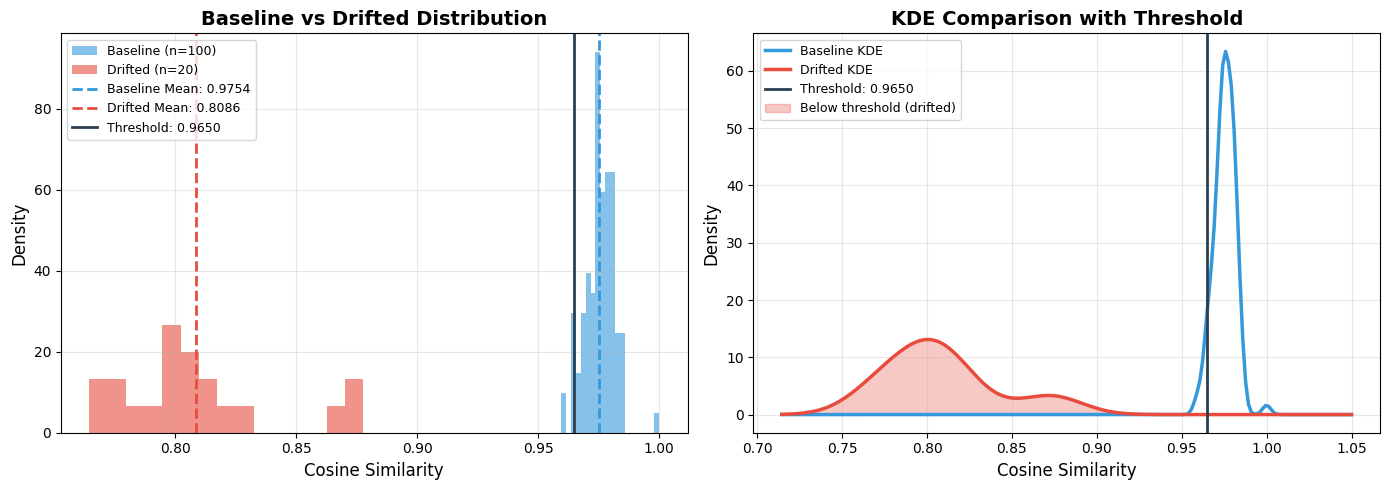


Rejection Rates:
  Baseline: 5.0%
  Drifted:  100.0%


In [29]:
# Visualize baseline vs drifted distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram comparison
ax1 = axes[0]
ax1.hist(baseline_stats["scores"], bins=20, alpha=0.6, color='#3498db', 
         label=f'Baseline (n={len(baseline_stats["scores"])})', density=True)
ax1.hist(drifted_sims, bins=15, alpha=0.6, color='#e74c3c', 
         label=f'Drifted (n={len(drifted_sims)})', density=True)
ax1.axvline(baseline_stats["mean"], color='#3498db', linestyle='--', linewidth=2, 
            label=f'Baseline Mean: {baseline_stats["mean"]:.4f}')
ax1.axvline(np.mean(drifted_sims), color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Drifted Mean: {np.mean(drifted_sims):.4f}')
ax1.axvline(threshold, color='#2c3e50', linestyle='-', linewidth=2, 
            label=f'Threshold: {threshold:.4f}')
ax1.set_xlabel('Cosine Similarity', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Baseline vs Drifted Distribution', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: KDE overlay
ax2 = axes[1]
x_range = np.linspace(min(min(baseline_stats["scores"]), min(drifted_sims)) - 0.05, 
                      max(max(baseline_stats["scores"]), max(drifted_sims)) + 0.05, 200)

kde_baseline = gaussian_kde(baseline_stats["scores"])
kde_drifted = gaussian_kde(drifted_sims)

ax2.plot(x_range, kde_baseline(x_range), color='#3498db', linewidth=2.5, label='Baseline KDE')
ax2.plot(x_range, kde_drifted(x_range), color='#e74c3c', linewidth=2.5, label='Drifted KDE')
ax2.axvline(threshold, color='#2c3e50', linestyle='-', linewidth=2, label=f'Threshold: {threshold:.4f}')

# Shade area below threshold for drifted distribution
x_fill = x_range[x_range < threshold]
ax2.fill_between(x_fill, kde_drifted(x_fill), alpha=0.3, color='#e74c3c', 
                 label='Below threshold (drifted)')

ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('KDE Comparison with Threshold', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate rejection rate
baseline_rejection_rate = np.mean(baseline_stats["scores"] < threshold) * 100
drifted_rejection_rate = np.mean(drifted_sims < threshold) * 100

print(f"\nRejection Rates:")
print(f"  Baseline: {baseline_rejection_rate:.1f}%")
print(f"  Drifted:  {drifted_rejection_rate:.1f}%")

## Step 13: Recalibration Strategy

Guidelines for when and how to recalibrate the threshold.

In [30]:
# Recalibration Strategy Documentation
recalibration_strategy = """
RECALIBRATION STRATEGY
======================

When to Recalibrate:
-------------------
1. Model version changes (OpenAI updates gpt-4o-mini)
2. System prompt changes materially
3. Embedding model changes (CRITICAL - thresholds become invalid!)
4. Drift detection triggers consistently
5. Observed acceptance/rejection rates shift significantly
6. Periodic schedule (e.g., monthly for production systems)

Dataset Split Strategy:
----------------------
When collecting new calibration data:
- Calibration Set (60-70%): Used to compute threshold
- Validation Set (20-30%): Used to verify threshold performance  
- Holdout Set (10%): Never touched during calibration, used for final audit

Important Notes:
---------------
- Do NOT use the same data for both drift detection and recalibration
- Keep audit samples untouched to avoid overfitting
- Log all calibration runs with timestamps for traceability
- Store reference embeddings separately for version control
"""

print(recalibration_strategy)


RECALIBRATION STRATEGY

When to Recalibrate:
-------------------
1. Model version changes (OpenAI updates gpt-4o-mini)
2. System prompt changes materially
3. Embedding model changes (CRITICAL - thresholds become invalid!)
4. Drift detection triggers consistently
5. Observed acceptance/rejection rates shift significantly
6. Periodic schedule (e.g., monthly for production systems)

Dataset Split Strategy:
----------------------
When collecting new calibration data:
- Calibration Set (60-70%): Used to compute threshold
- Validation Set (20-30%): Used to verify threshold performance  
- Holdout Set (10%): Never touched during calibration, used for final audit

Important Notes:
---------------
- Do NOT use the same data for both drift detection and recalibration
- Keep audit samples untouched to avoid overfitting
- Log all calibration runs with timestamps for traceability
- Store reference embeddings separately for version control



## Step 14: Export Calibration Results

Save calibration results for production use.

In [31]:
from datetime import datetime

# Create calibration results dictionary
calibration_results = {
    "metadata": {
        "calibration_date": datetime.now().isoformat(),
        "n_samples": N_OUTPUTS,
        "generation_model": GENERATION_MODEL,
        "embedding_model": EMBEDDING_MODEL,
        "temperature": TEMPERATURE
    },
    "threshold": {
        "value": float(threshold),
        "percentile": THRESHOLD_PERCENTILE,
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "confidence_level": CONFIDENCE_LEVEL
    },
    "baseline_statistics": {
        "mean": float(baseline_stats["mean"]),
        "std": float(baseline_stats["std"]),
        "min": float(np.min(baseline_stats["scores"])),
        "max": float(np.max(baseline_stats["scores"]))
    },
    "drift_detection_config": {
        "window_size": DRIFT_WINDOW_SIZE,
        "ks_alpha": DRIFT_ALPHA,
        "z_threshold": DRIFT_Z_THRESHOLD
    }
}

# Display results
print("CALIBRATION RESULTS")
print("=" * 60)
print(json.dumps(calibration_results, indent=2))
print("=" * 60)

# Optionally save to file
# with open("calibration_results.json", "w") as f:
#     json.dump(calibration_results, f, indent=2)
# print("\nResults saved to calibration_results.json")

CALIBRATION RESULTS
{
  "metadata": {
    "calibration_date": "2026-01-22T16:33:21.747692",
    "n_samples": 100,
    "generation_model": "gpt-4o-mini",
    "embedding_model": "text-embedding-3-small",
    "temperature": 0.2
  },
  "threshold": {
    "value": 0.9649647062163639,
    "percentile": 5,
    "ci_low": 0.9637511023629896,
    "ci_high": 0.9678835715199489,
    "confidence_level": 0.95
  },
  "baseline_statistics": {
    "mean": 0.9753533878004191,
    "std": 0.006170802358993457,
    "min": 0.9595344289272731,
    "max": 1.0000000000000004
  },
  "drift_detection_config": {
    "window_size": 50,
    "ks_alpha": 0.05,
    "z_threshold": 2
  }
}


## Summary and Next Steps

Final summary of calibration results and operational recommendations.

In [32]:
print("""
================================================================================
                      CALIBRATION SUMMARY
================================================================================
""")

print(f"CALIBRATED THRESHOLD")
print(f"  Value:            {threshold:.4f}")
print(f"  95% CI:           [{ci_low:.4f}, {ci_high:.4f}]")
print(f"  Percentile:       {THRESHOLD_PERCENTILE}th")
print()

print(f"BASELINE DISTRIBUTION")
print(f"  Mean:             {baseline_stats['mean']:.4f}")
print(f"  Std:              {baseline_stats['std']:.4f}")
print(f"  N samples:        {len(baseline_stats['scores'])}")
print()

print(f"OPERATIONAL POLICY")
print(f"  IF score >= {threshold:.4f}  --> ACCEPT")
print(f"  IF score <  {threshold:.4f}  --> RETRY (up to 3 times)")
print(f"  IF still below threshold  --> ESCALATE")
print()

print(f"DRIFT MONITORING")
print(f"  Window size:      {DRIFT_WINDOW_SIZE} samples")
print(f"  KS test alpha:    {DRIFT_ALPHA}")
print(f"  Mean shift z:     {DRIFT_Z_THRESHOLD}")
print()

print("""
NEXT STEPS:
-----------
1. Integrate threshold into production runtime
2. Implement drift monitoring pipeline
3. Set up alerting for drift detection
4. Schedule periodic recalibration (e.g., monthly)
5. Track acceptance/rejection rates over time

IMPORTANT CAVEATS:
-----------------
- Cosine similarity alone won't catch format/structure violations
- Add hard validators for JSON schema, required fields, etc.
- Self-consistency != correctness (you can be consistently wrong)
- Recalibrate when embedding model changes (thresholds invalidated!)
================================================================================
""")


                      CALIBRATION SUMMARY

CALIBRATED THRESHOLD
  Value:            0.9650
  95% CI:           [0.9638, 0.9679]
  Percentile:       5th

BASELINE DISTRIBUTION
  Mean:             0.9754
  Std:              0.0062
  N samples:        100

OPERATIONAL POLICY
  IF score >= 0.9650  --> ACCEPT
  IF score <  0.9650  --> RETRY (up to 3 times)
  IF still below threshold  --> ESCALATE

DRIFT MONITORING
  Window size:      50 samples
  KS test alpha:    0.05
  Mean shift z:     2


NEXT STEPS:
-----------
1. Integrate threshold into production runtime
2. Implement drift monitoring pipeline
3. Set up alerting for drift detection
4. Schedule periodic recalibration (e.g., monthly)
5. Track acceptance/rejection rates over time

IMPORTANT CAVEATS:
-----------------
- Cosine similarity alone won't catch format/structure violations
- Add hard validators for JSON schema, required fields, etc.
- Self-consistency != correctness (you can be consistently wrong)
- Recalibrate when embedding 